# PP5: deep learning intro

<a href="https://colab.research.google.com/github/PauliusU/PP5-deep-learning-intro/blob/master/PP5_deep_learning_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Choosing dataset and problem to solve

Project will use Iris dataset for polynomial non-linearly separable classification.

In Iris dataset there are three classes, Setosa is linearly separable from the other two classes. Versicolor and Virginica classes are not linearly separable (see [source](https://www.researchgate.net/figure/Iris-data-set-There-are-three-classes-Setosa-class-is-linearly-separable-from-the-other_fig2_300643220)).

Therefore, the project will use only Versicolor and Virginica classes from the Iris dataset.

In [51]:
# Load the dataset

from pprint import pprint
from sklearn.datasets import load_iris

# Initiate Iris flower dataset
dataset = load_iris()
pprint(dataset)

print(dataset["target"])

{'DESCR': '.. _iris_dataset:\n'
          '\n'
          'Iris plants dataset\n'
          '--------------------\n'
          '\n'
          '**Data Set Characteristics:**\n'
          '\n'
          '    :Number of Instances: 150 (50 in each of three classes)\n'
          '    :Number of Attributes: 4 numeric, predictive attributes and the '
          'class\n'
          '    :Attribute Information:\n'
          '        - sepal length in cm\n'
          '        - sepal width in cm\n'
          '        - petal length in cm\n'
          '        - petal width in cm\n'
          '        - class:\n'
          '                - Iris-Setosa\n'
          '                - Iris-Versicolour\n'
          '                - Iris-Virginica\n'
          '                \n'
          '    :Summary Statistics:\n'
          '\n'
          '    ============== ==== ==== ======= ===== ====================\n'
          '                    Min  Max   Mean    SD   Class Correlation\n'
          '  

In [52]:
import pandas as pd

# Initiate pandas DataFrame with first 4 attributes
df = pd.DataFrame(dataset["data"], columns=[
                  "setal length", "setal width", "petal length", "petal width"])
# Add last (5th) attribute
df["species"] = dataset["target"]
df["species"] = df["species"].apply(lambda x: dataset["target_names"][x])
# Remove rows containing linear "setosa" species
df = df.drop(df[df.species == 'setosa' ].index)
# Reindex
df.reset_index(drop=True, inplace=True)

# Get basic info about DataFrame
print(df.info)  # Concise summary of a DataFrame.
print(df.shape)  # (150, 5)
print(df.head())  # First 5 records
print(df.describe())  # Descriptive statistics
print(df.isnull().sum())
print(df.groupby("species").size())  # Group sizes for each species (class)

<bound method DataFrame.info of     setal length  setal width  petal length  petal width     species
0            7.0          3.2           4.7          1.4  versicolor
1            6.4          3.2           4.5          1.5  versicolor
2            6.9          3.1           4.9          1.5  versicolor
3            5.5          2.3           4.0          1.3  versicolor
4            6.5          2.8           4.6          1.5  versicolor
..           ...          ...           ...          ...         ...
95           6.7          3.0           5.2          2.3   virginica
96           6.3          2.5           5.0          1.9   virginica
97           6.5          3.0           5.2          2.0   virginica
98           6.2          3.4           5.4          2.3   virginica
99           5.9          3.0           5.1          1.8   virginica

[100 rows x 5 columns]>
(100, 5)
   setal length  setal width  petal length  petal width     species
0           7.0          3.2          

In [53]:
# Before implementing any model we need to split the dataset to train and test sets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split the data into X and y
X = df.iloc[:,0:4].values
y = df.iloc[:,4].values

# Verify splitting
print(X.shape) # (100, 4)
print(y.shape) # (100,)

# Convert target into LabelEncoder
# Encode target labels with value between 0 and n_classes-1.
# This transformer should be used to encode target values, i.e. y, and not the input X.
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y) # Fit label encoder and return encoded labels.
print(y1)

# Convert X and Y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Verify splitting again
print(X_train[0:3])
print(X_test[0:3])
print(y_train[0:3])
print(y_test[0:3])

# # Split the dataset to 70% as train and 30% as test datasets
# train, test = train_test_split(df, test_size=0.3)

# # Verify splitting results
# print(train.shape)  # (105, 5)
# print(test.shape)  # (45, 5)

# # Split the train and test sets further as input and output sets
# train_X = train[["setal length", "setal width", "petal length", "petal width"]]
# train_y = train.species
# test_X = test[["setal length", "setal width", "petal length", "petal width"]]
# test_y = test.species

# # Verify splitting results again
# print(train_X.shape)
# print(train_y.shape)
# print(test_X.shape)
# print(test_y.shape)

(100, 4)
(100,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[5.  2.3 3.3 1. ]
 [6.8 3.  5.5 2.1]
 [5.5 2.3 4.  1.3]]
[[6.8 2.8 4.8 1.4]
 [6.3 3.4 5.6 2.4]
 [6.9 3.1 4.9 1.5]]
['versicolor' 'virginica' 'versicolor']
['versicolor' 'virginica' 'versicolor']


## Keras

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [55]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=2)

n_features = X.shape[1]
n_classes = Y.shape[1]

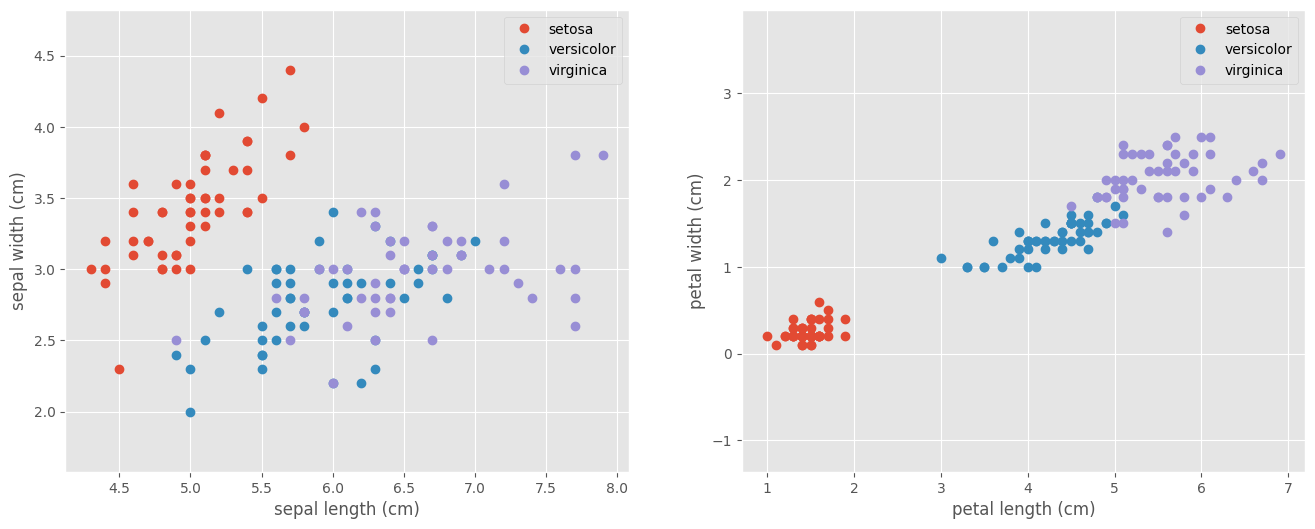

In [56]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

In [57]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras.layers import Dense

def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        for i in range(n):
            model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
        model.add(Dense(output_dim, activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        return model
    return create_model

models = [create_custom_model(n_features, n_classes, 8, i, 'model_{}'.format(i)) 
          for i in range(1, 4)]

for create_model in models:
    create_model().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 3)        

In [58]:
from keras.callbacks import TensorBoard

history_dict = {}

# TensorBoard Callback
cb = TensorBoard()

for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_dict[model.name] = [history_callback, model]

Model name: model_1
Test loss: 0.3344988524913788
Test accuracy: 0.9200000166893005
Model name: model_2
Test loss: 0.15185770392417908
Test accuracy: 0.9599999785423279
Model name: model_3
Test loss: 0.45192840695381165
Test accuracy: 0.9333333373069763


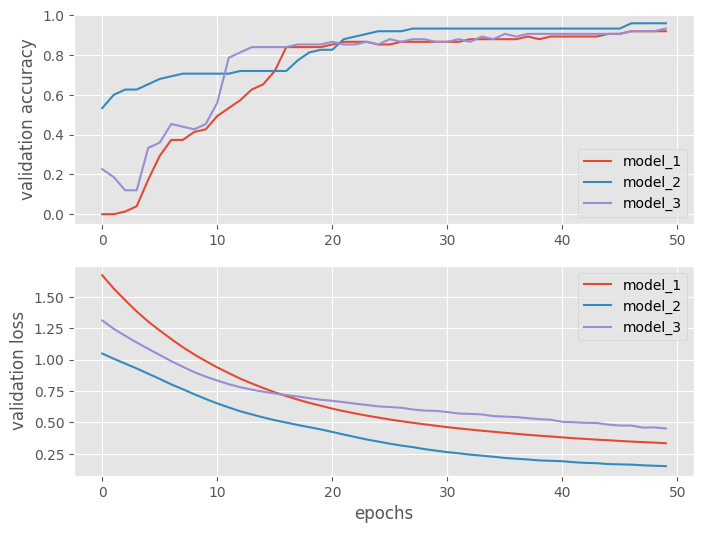

In [59]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_accurady = history_dict[model_name][0].history['val_accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_accurady, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

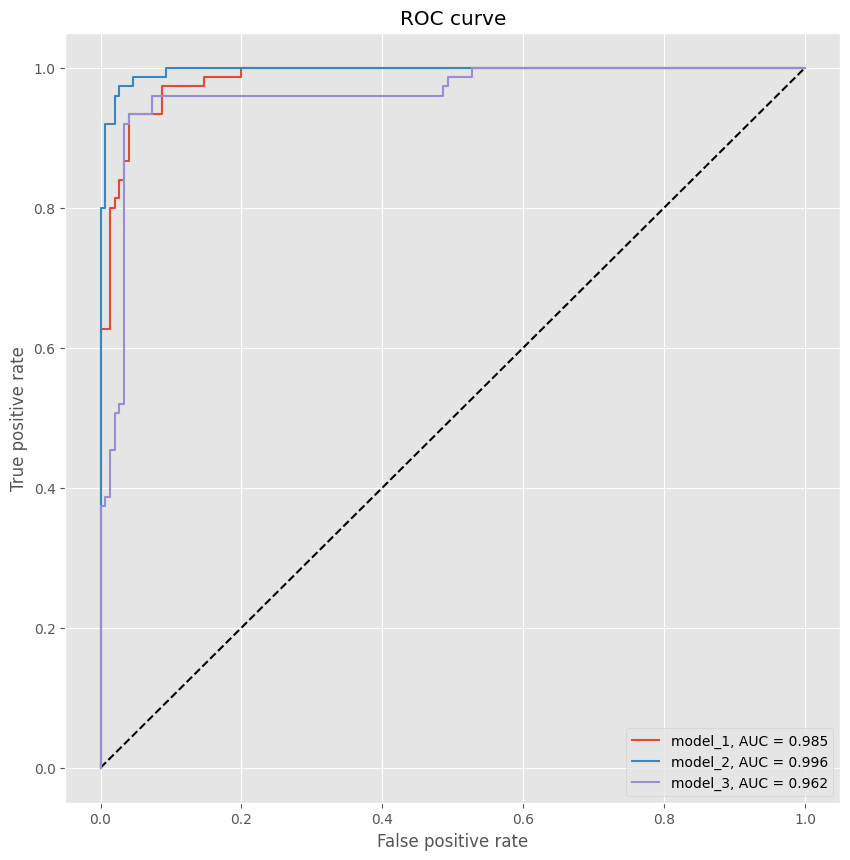

In [60]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

for model_name in history_dict:
    model = history_dict[model_name][1]
    
    Y_pred = model.predict(X_test)
    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
    
    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(model_name, auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [61]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

create_model = create_custom_model(n_features, n_classes, 8, 3)

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=0)
scores = cross_val_score(estimator, X_scaled, Y, cv=10)
print("Accuracy : {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std()))

Accuracy : 0.93 (+/- 0.08)


## PyTorch

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [63]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
# X = iris['data'][50:]
# y = iris['target'][50:]
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# print(X)
print(len(X))
print(len(y))

# df = df.drop(df[df.species == 'setosa' ].index)
# # Reindex
# df.reset_index(drop=True, inplace=True)

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled)
print(len(X_scaled))

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

150
150
[[-9.00681170e-01  1.01900435e+00 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00 -1.31979479e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.38535265e+00  3.28414053e-01 -1.39706395e+00 -1.31544430e+00]
 [-1.50652052e+00  9.82172869e-02 -1.28338910e+00 -1.31544430e+00]
 [-1.02184904e+00  1.24920112e+00 -1.34022653e+00 -1.31544430e+00]
 [-5.37177559e-01  1.93979142e+00 -1.16971425e+00 -1.05217993e+00]
 [-1.50652052e+00  7.88807586e-01 -1.34022653e+00 -1.18381211e+00]
 [-1.02184904e+00  7.88807586e-01 -1.28338910e+00 -1.31544430e+00]
 [-1.74885626e+00 -3.62176246e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00  9.82172869e-02 -1.28338910e+00 -1.44707648e+00]
 [-5.37177559e-01  1.47939788e+00 -1.28338910e+00 -1.31544430e+00]
 [-1.26418478e+00  7.88807586e-01 -1.22655167e+00 -1.31544430e+00]
 [-1.26418478e+00 -1.31979479e-01 -1.34022653e+00 -1.44707648e+00]
 [-1.87002413e+00 -1.31979479e-01 -1.51073881e+00 -1.44707648e+00]
 [-5.25060772e-02  2.16998818e+00 -1.45390138e+00 -1.3

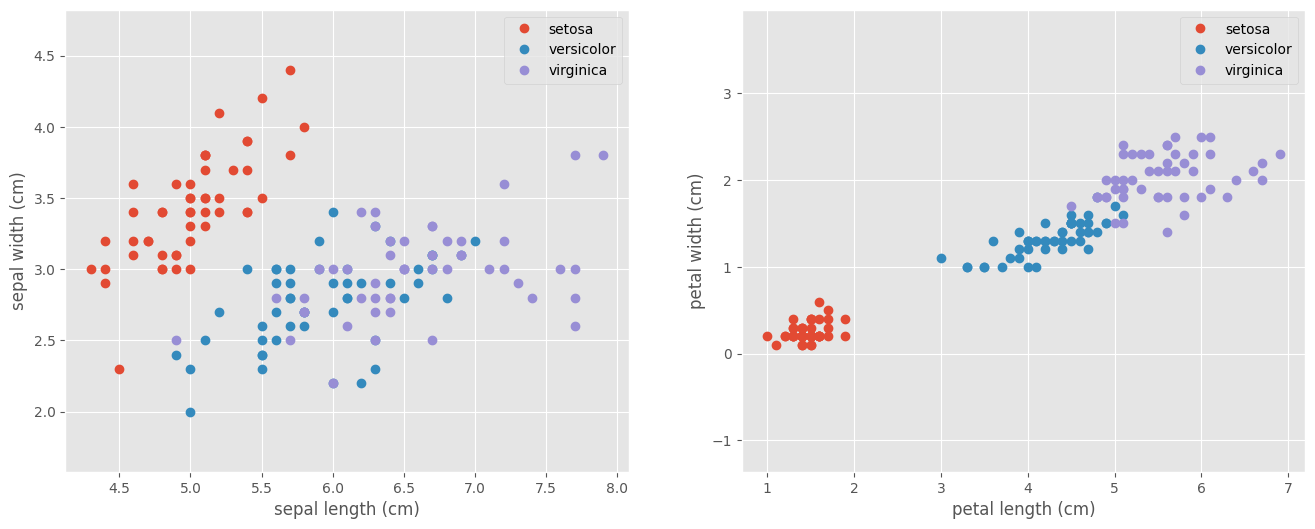

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

In [65]:
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

1.12.1+cpu


In [66]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [67]:
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
print(model)

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)


In [68]:
import tqdm

EPOCHS  = 300
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 300/300 [00:00<00:00, 387.17it/s]


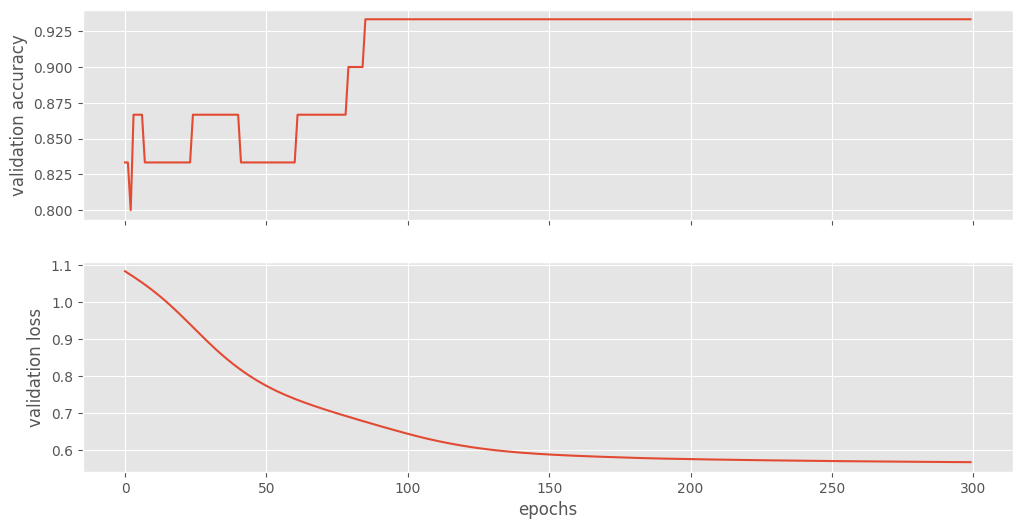

In [69]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

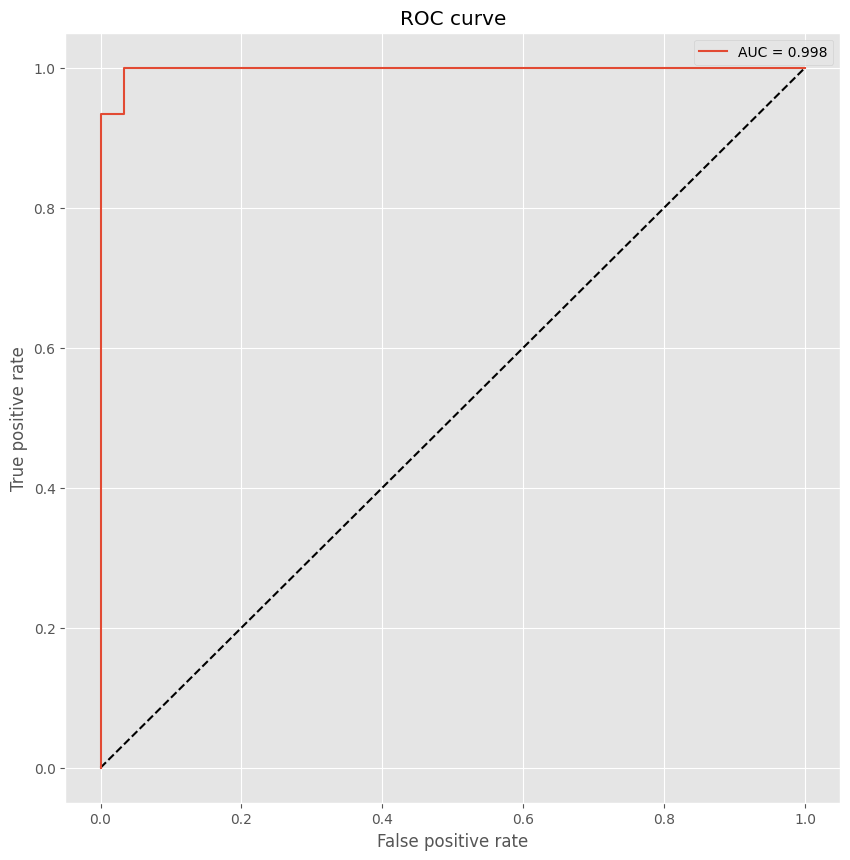

In [70]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();